# Importing necessary packages for Excersise

In [ ]:
# Please uncomment this line if you find troubles downloading STL composite of statsmodels in the following cells
#Need to make sure that we use latest version of statsmodels package - actually it is not installed in Colab

# !pip install git+https://github.com/statsmodels/statsmodels

# Getting some data

Unzip + Preprocessing

We will be using data from following range: 

- 1.01.2000 - 31.12.2001

In [ ]:
!wget http://solardat.uoregon.edu/download/temp/47646112.zip -O /tmp/solar.zip

--2020-04-07 16:18:41--  http://solardat.uoregon.edu/download/temp/47646112.zip
Resolving solardat.uoregon.edu (solardat.uoregon.edu)... 128.223.93.66
Connecting to solardat.uoregon.edu (solardat.uoregon.edu)|128.223.93.66|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2589091 (2.5M) [application/zip]
Saving to: ‘/tmp/solar.zip’

/tmp/solar.zip      100%[===================>]   2.47M  3.24MB/s    in 0.8s    

2020-04-07 16:18:41 (3.24 MB/s) - ‘/tmp/solar.zip’ saved [2589091/2589091]



In [ ]:
import os
import zipfile

local_zip = '/tmp/solar.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()
!rm -rf /tmp/solar.zip #Removing zip file

In [ ]:
#Check the folder

solar_dir = os.path.join("/tmp/")
print("Total files in solar dir: {}".format(len(os.listdir(solar_dir))))

Total files in solar dir: 24


In [ ]:
#Check single file

!head -6 /tmp/ABRF0001.txt

94174	2000	1002	0	3002	0	9301	0	9331	0	9152	0	9201	0	9211	0
1	5	-1	13	0	13	-5.5	11	84.1	11	0	11	235.1	11	2.1	11
1	10	-1	13	0	11	-5.4	11	84.2	11	0	11	228.7	11	1.9	11
1	15	-1	13	0	11	-5.2	11	84.1	11	0	11	219	11	1.9	11
1	20	-1	13	0	11	-5.1	11	83.9	11	0	11	209.2	11	2.7	11
1	25	-1	13	0	11	-5.1	11	84.2	11	0	11	209.1	11	2.6	11


# Data Loading + preprocessing

In [ ]:
#Let's get all files in single filepaths

filepaths = [os.path.join(solar_dir, x) for x in os.listdir(solar_dir)]

In [ ]:
#Sort files by last 8 digits - those are year and month number

filepaths = sorted(filepaths, key= lambda x: x[-8:])

In [ ]:
#Quick check 
filepaths[:10]

['/tmp/ABRF0001.txt',
 '/tmp/ABRF0002.txt',
 '/tmp/ABRF0003.txt',
 '/tmp/ABRF0004.txt',
 '/tmp/ABRF0005.txt',
 '/tmp/ABRF0006.txt',
 '/tmp/ABRF0007.txt',
 '/tmp/ABRF0008.txt',
 '/tmp/ABRF0009.txt',
 '/tmp/ABRF0010.txt']

In [ ]:
#Import our files
#Let's work on first 12 files

import csv

day_of_year = []
time=[]
ts=[]


for fl in filepaths:
  with open(fl, "r") as f:
    next(f) #to skip the header
    reader = csv.reader(f, delimiter="\t")
    for row in reader:
      day_of_year.append(int(row[0]))
      time.append(int(row[1]))
      ts.append(int(row[2]))

In [ ]:
print("Length of days: {}".format(len(day_of_year)))
print("Length of radiance values: {}".format(len(ts)))

Length of days: 210528
Length of radiance values: 210528


#EDA

Let's try to investigate the data for anomalies. 
What are anomalies? 

According to popular dictionary: "*something that deviates from what is standard, normal, or expected.*" 

This is exactly what we will focus on. 
Let's load some sample of data and invastigate that for anomalies


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


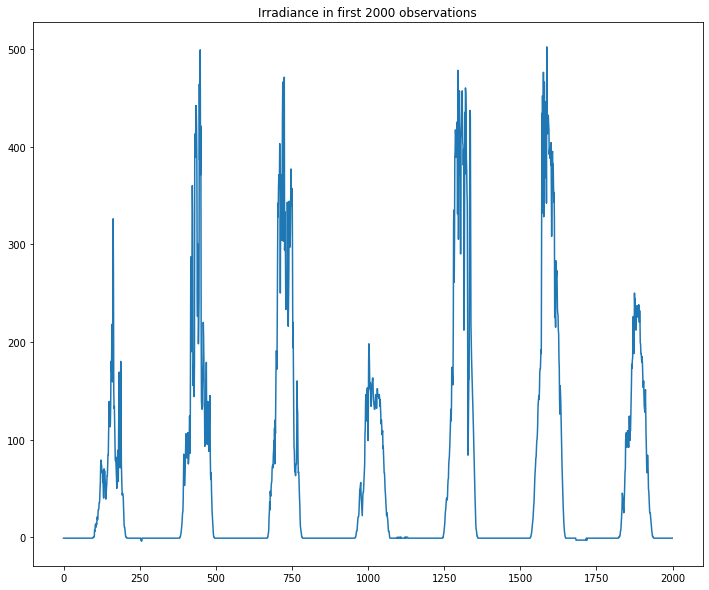

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))

ax.plot(ts[:2000])
ax.set_title('Irradiance in first 2000 observations')


fig.show()

In [ ]:
import numpy as np

print("Minimum value observed is: {}".format(np.min(ts)))
print("Maximum value observed is: {}".format(np.max(ts)))
print("Mean value observed is {}".format(np.mean(ts)))

Minimum value observed is: -999
Maximum value observed is: 1282
Mean value observed is 167.02893201854386


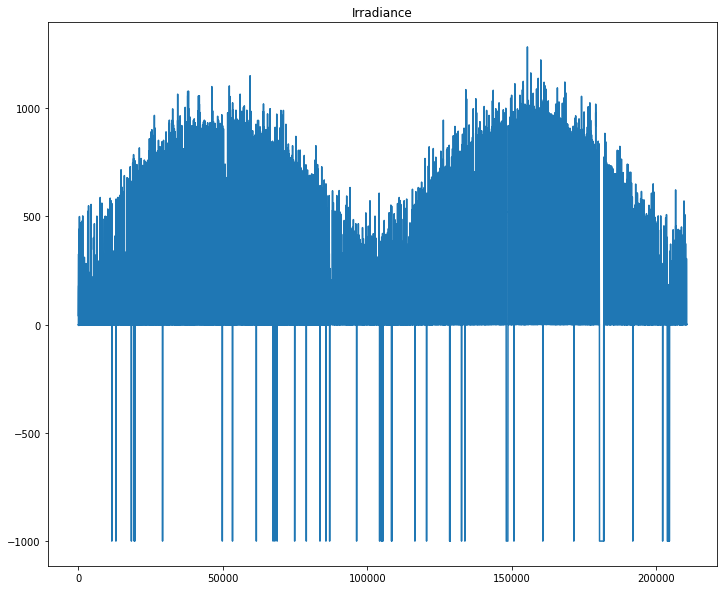

In [ ]:
#Negative values? - let's plot our full set

fig, ax = plt.subplots(figsize=(12,10))

ax.plot(ts)
ax.set_title('Irradiance')


fig.show()

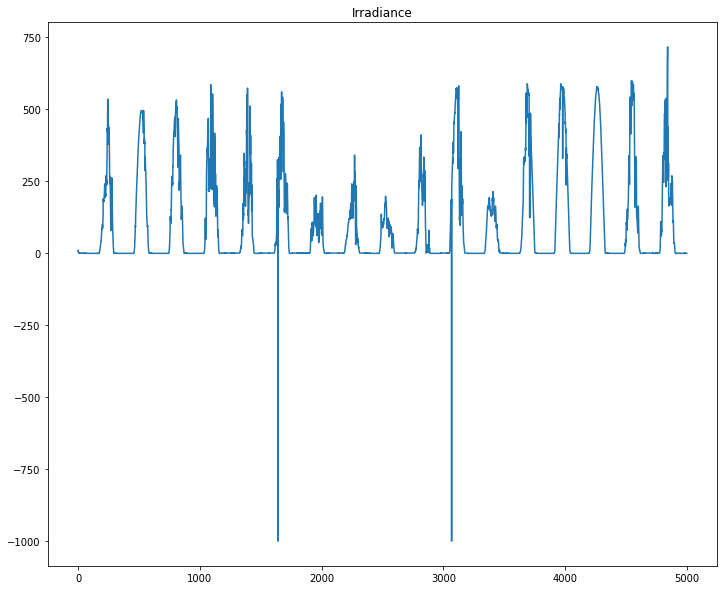

In [ ]:
#Let's zoom in into values between 10000:15000

fig, ax = plt.subplots(figsize=(12,10))

ax.plot(ts[10000:15000])
ax.set_title('Irradiance')


fig.show()

**Comment**

Looks like negtive values for irradiance are abnormal - probably caused by equipment error

Source: https://www.quora.com/What-do-negative-values-for-global-horizontal-radiance-measurements-in-solar-panels-mean


# Anomaly Detection
#let's focus on those 5k observations



Following approaches would be tried:

1. Twitter AnomalyDetection package
2. STL Decomposition
3. Use more complex models (Isolation Forest etc.)


In [ ]:
#Looks like we need to specify period by hand
#Since we observations that happens every 5 minutes, so we have 288 observations during the day. Let's try to set period for daily observations = 12*24
import statsmodels.api as sm


decomposition = sm.tsa.seasonal_decompose(ts, period=288)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

Let's plot our super fancy decomposition. 

Note: Using first 10k observations for better visuality

Text(0.5, 1.0, 'Observed values')

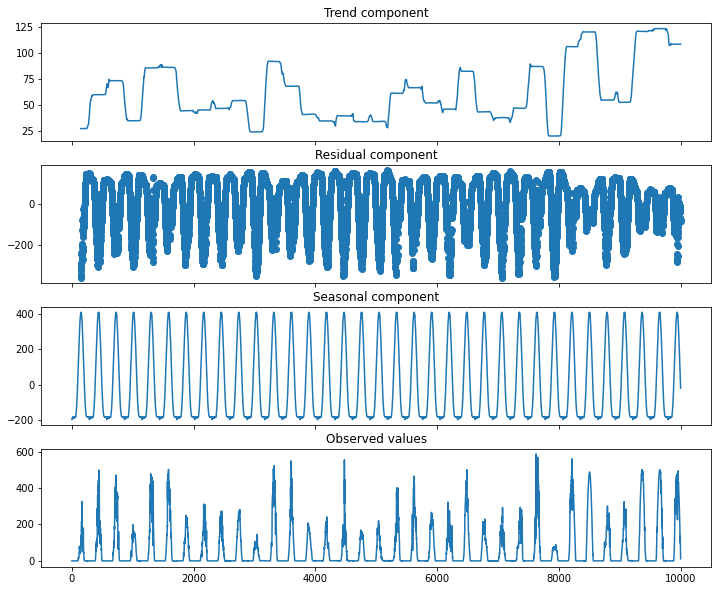

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

axs[0].plot(decomposition.trend[:10000])
axs[0].set_title("Trend component")
axs[1].scatter(y=decomposition.resid[:10000], x=np.arange(len(decomposition.resid[:10000])))
axs[1].set_title("Residual component")
axs[2].plot(decomposition.seasonal[:10000])
axs[2].set_title("Seasonal component")
axs[3].plot(decomposition.observed[:10000])
axs[3].set_title("Observed values")

**Using STL function with LOESS method implemented**

This time with seasonality set to 288 (full day of observations)


In [ ]:
from statsmodels.tsa.seasonal import STL

stl = STL(ts, period=288).fit()


Text(0.5, 1.0, 'Observed')

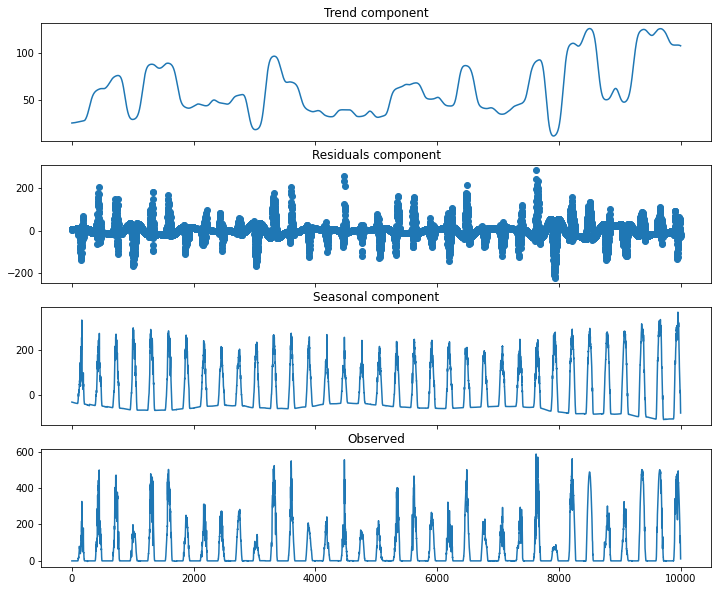

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

axs[0].plot(stl.trend[:10000])
axs[0].set_title("Trend component")
axs[1].scatter(y=stl.resid[:10000], x=np.arange(len(stl.resid[:10000])))
axs[1].set_title("Residuals component")
axs[2].plot(stl.seasonal[:10000])
axs[2].set_title("Seasonal component")
axs[3].plot(stl.observed[:10000])
axs[3].set_title("Observed")

**Anomaly Detection in STL**

While doing STL decomposition what we care about are residuals. 
We can clearly see, that there are several peaks in both directions: upward and down. 
Basically, we would like our residual plot to be as flat as possible, however sometimes it is just not possible. 

Best way to dermine wheter an observation is anomaly is to plot histogram and decide at threshold level for monitoring, e.g. 99.7% (three sigmas)
Because of law of large numbers, we can expect to see nicely shaped Bell Curve aka. Gaussian Distribution.  

More about production ready anomaly detection systems: 

https://medium.com/pinterest-engineering/building-a-real-time-anomaly-detection-system-for-time-series-at-pinterest-a833e6856ddd




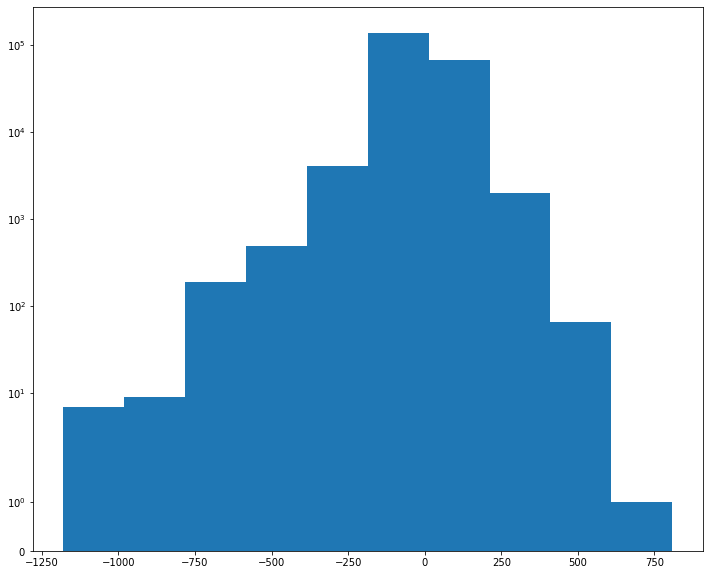

In [ ]:
fig, axs = plt.subplots(figsize=(12, 10), sharex=True)

axs.hist(stl.resid)
axs.set_yscale("symlog")

**Threshold**

Right now it is completely up to us what kind of threshold we want to set.
Let's follow the rule described by Pinterest - 3 sigmas


In [ ]:
import numpy as np

resid = stl.resid
three_sigmas = 3*np.std(resid)

mask = np.where(np.logical_or(resid<-three_sigmas, resid>three_sigmas))
anomalies = resid[mask]

In [ ]:
#Print out some anomalies
print("Our boundaries are the following, upper: {} and lower: {}".format(three_sigmas, -three_sigmas))
print("\n")

print("Some anomalies: {}".format(anomalies[:10]))

Our boundaries are the following, upper: 223.49280623200872 and lower: -223.49280623200872


Some anomalies: [ 260.05903297  232.81168756  285.59866563  244.49382849  233.13565295
 -224.45237985  274.74591474 -834.6454541   287.81154704  246.81700476]


#### Plotting

Let's visualize those anomalies on chart

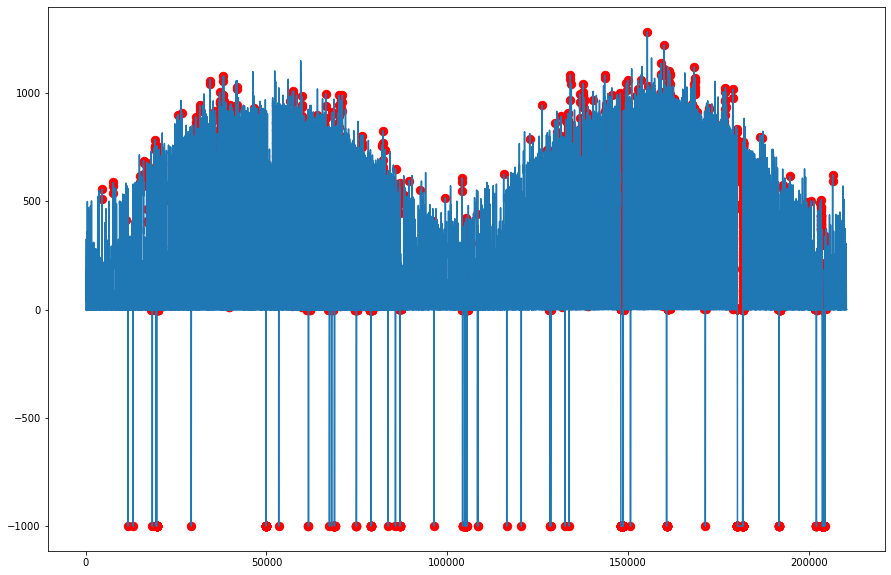

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

ax.plot(ts)
ax.scatter(y=np.array(ts)[mask], x=mask, c="red", s=70)

Zoom our plot to let's say observations that are between 50k:55k

In [ ]:
mask_55 = np.where(np.logical_or(resid[50000:55000]<-three_sigmas, resid[50000:55000]>three_sigmas))
ts_55 = ts[50000:55000]

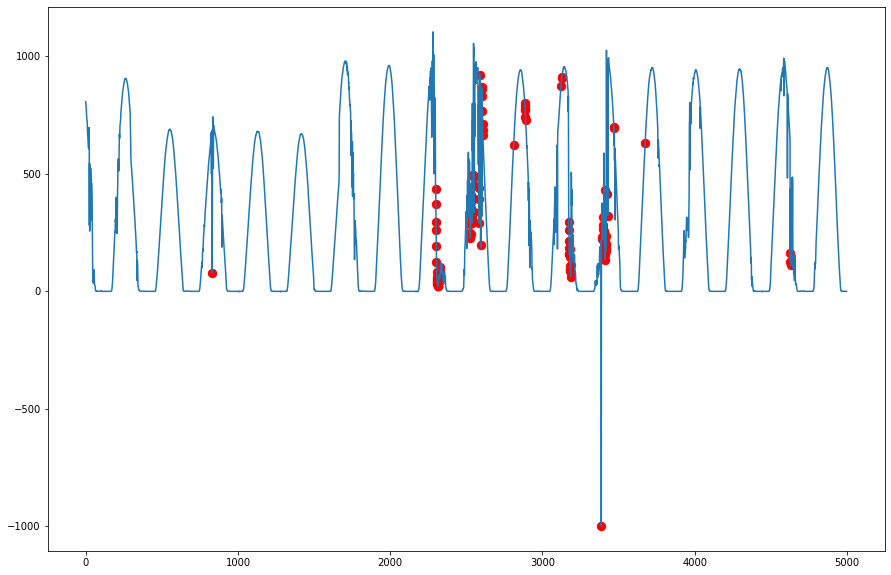

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

ax.plot(ts_55)
ax.scatter(y=np.array(ts_55)[mask_55], x=mask_55, c="red", s=70)

So, not only high peaks were considered anomalies, but also some other values that were not abnormal at first sight


Final thoughts:

1. It is hard to determine the "accuracy" of anomaly detection, since we don't have labeled dataset here. 
Detected anomalies seems to be abnormal, for example: all low peaks were catched as par as some high ones, which were not cosidered abnormal from the first sight. 

2. In such configuration, the amount of anomalies is obviosly determined by the threshold values defined above. Reducing the sigmas would result in more anomalies.Again, it should be consulted with business first, what we are considering anomalies and what is not. 

# Drop all negative peaks

And re-run algorithm again. 
It should not change our results much, however it might be beneficial for visual understanding of anomalies

In [ ]:
#Drop all negative peaks below -2. Why -2? While analyzing data I noticed that there are a lot of "-1" values - Could be device issue
ts_new = np.array(ts)[np.array(ts) > -2]

In [ ]:
len(ts_new)

207292

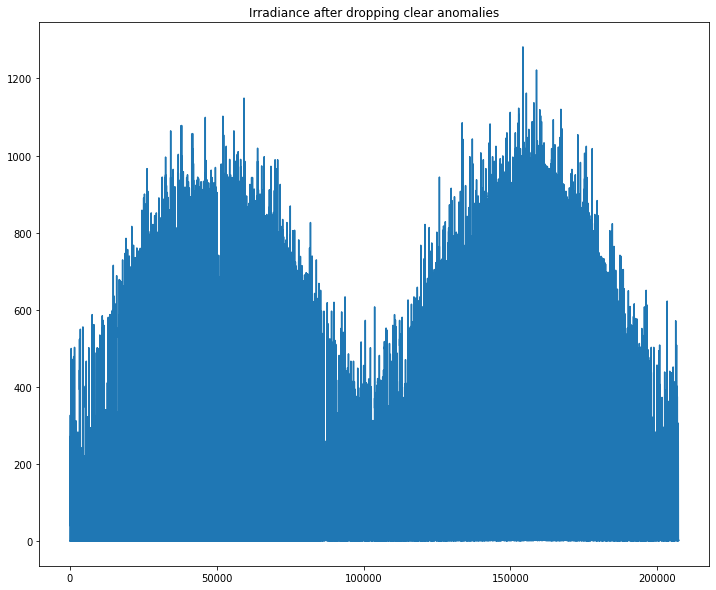

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))

ax.plot(ts_new)
ax.set_title('Irradiance after dropping clear anomalies')


fig.show()

# Re-run STL on new data

In [ ]:
#Again seasonality set to 288

from statsmodels.tsa.seasonal import STL

stl = STL(ts_new, period=288).fit()


Text(0.5, 1.0, 'Observed')

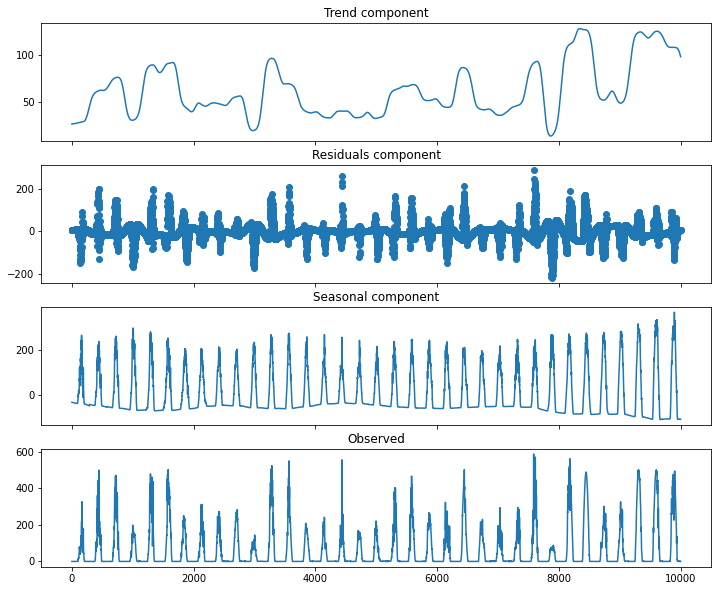

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

axs[0].plot(stl.trend[:10000])
axs[0].set_title("Trend component")
axs[1].scatter(y=stl.resid[:10000], x=np.arange(len(stl.resid[:10000])))
axs[1].set_title("Residuals component")
axs[2].plot(stl.seasonal[:10000])
axs[2].set_title("Seasonal component")
axs[3].plot(stl.observed[:10000])
axs[3].set_title("Observed")

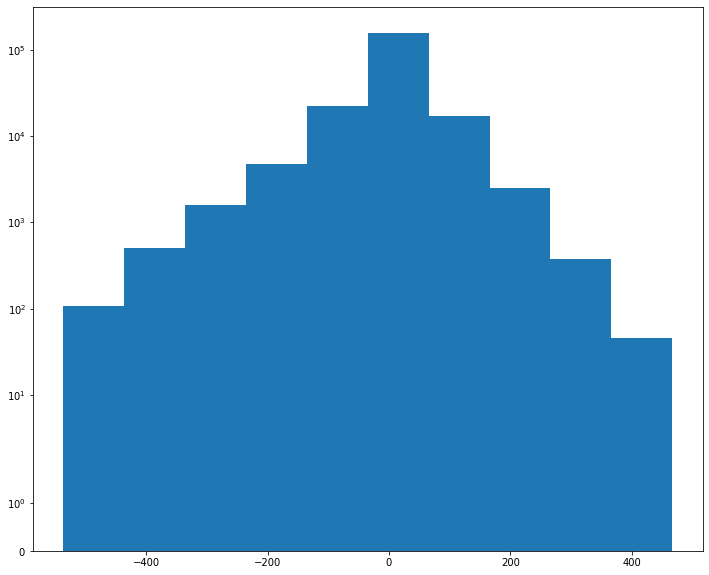

In [ ]:
fig, axs = plt.subplots(figsize=(12, 10), sharex=True)

axs.hist(stl.resid)
axs.set_yscale("symlog")

**Comment**

Histogram looks more centered, however we still have some skewness

Regarding the subplots from STL, it does not change much - let's calculate anomalies and plot them on chart

In [ ]:
resid = stl.resid
three_sigmas = 3*np.std(resid)

mask = np.where(np.logical_or(resid<-three_sigmas, resid>three_sigmas))
anomalies = resid[mask]

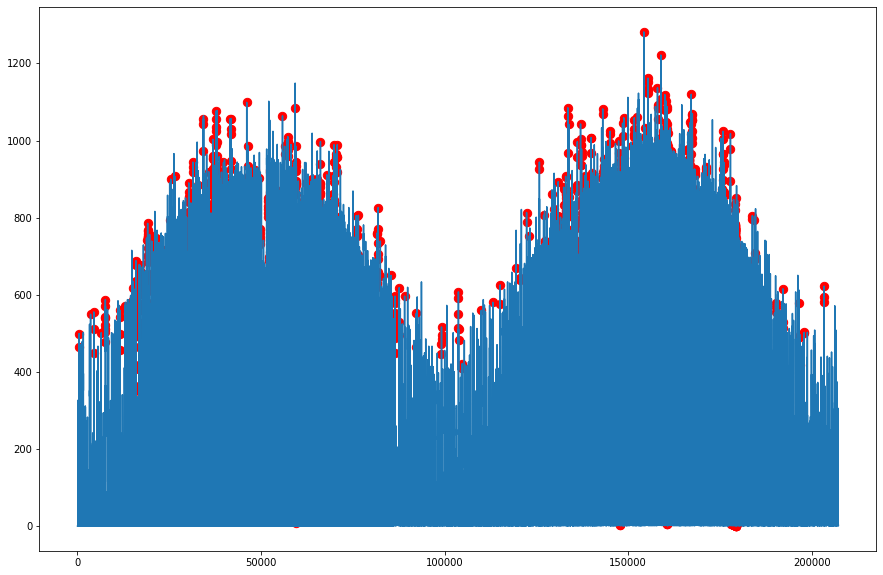

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

ax.plot(ts_new)
ax.scatter(y=np.array(ts_new)[mask], x=mask, c="red", s=70)

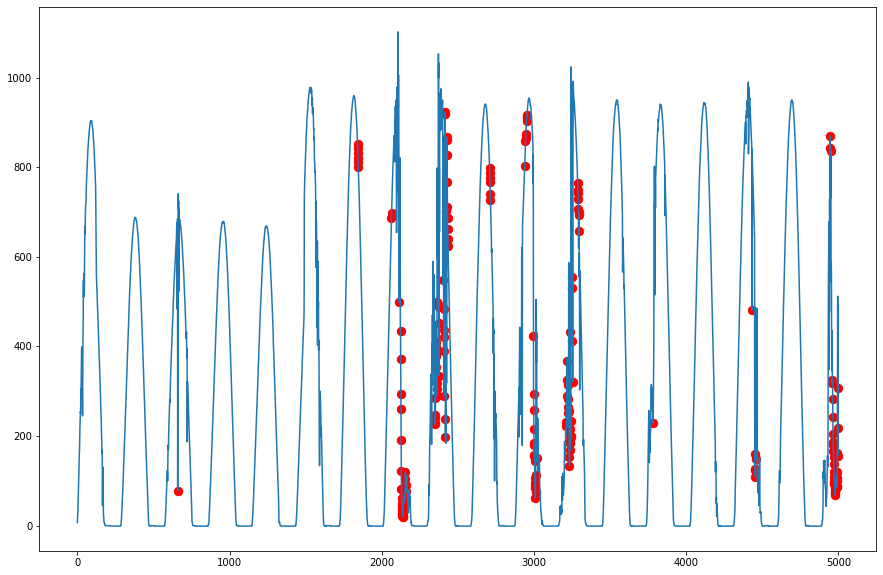

In [ ]:
#Again, zooming to 5k observations, between 50k:55k

mask_55 = np.where(np.logical_or(resid[50000:55000]<-three_sigmas, resid[50000:55000]>three_sigmas))
ts_55 = ts_new[50000:55000]

fig, ax = plt.subplots(figsize=(15,10))

ax.plot(ts_55)
ax.scatter(y=np.array(ts_55)[mask_55], x=mask_55, c="red", s=70)

# Plot clear plot without anomalies

Text(0.5, 1.0, 'Cleaned')

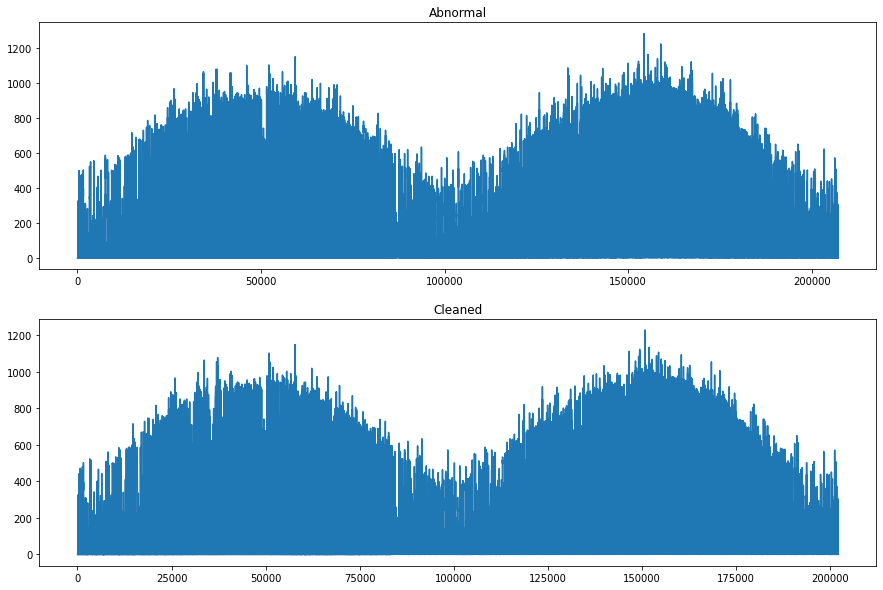

In [ ]:
clear = np.ones(len(ts_new), bool)
clear[mask] = False

fig, axs = plt.subplots(2,1, figsize=(15,10))

#First plot - abnormal
axs[0].plot(ts_new)
axs[0].set_title("Abnormal")
axs[1].plot(ts_new[clear])
axs[1].set_title("Cleaned")

In [ ]:
#Write this file into csv file that could be used to train NN -prediction

np.savetxt("/content/sample_data/nn-input.csv", ts_new, delimiter=",")
